# Can Congress and Twitter data be linked?

>How to use Congress API: https://github.com/eyeseast/propublica-congress/blob/master/docs/api.rst

In [134]:
import tweepy
import pandas as pd

## Set up Congress API: Senate

In [135]:
from congress import Congress

congress = Congress('qa1qfTzGinGGLcNCbinp2OTlI2SvzBe4KFgxYobm')

# get member by bioguide ID
senate = congress.members.filter('senate')

In [129]:
#access members in dict
sen_members = senate[0]['members']

#save in df
df_senate = pd.DataFrame(sen_members)
df_senate.columns #twitter_account gives twitter name

Index(['api_uri', 'contact_form', 'crp_id', 'cspan_id', 'date_of_birth',
       'dw_nominate', 'facebook_account', 'fax', 'fec_candidate_id',
       'first_name', 'gender', 'google_entity_id', 'govtrack_id', 'icpsr_id',
       'id', 'ideal_point', 'in_office', 'last_name', 'leadership_role',
       'lis_id', 'middle_name', 'missed_votes', 'missed_votes_pct',
       'next_election', 'ocd_id', 'office', 'party', 'phone', 'rss_url',
       'senate_class', 'seniority', 'short_title', 'state', 'state_rank',
       'suffix', 'title', 'total_present', 'total_votes', 'twitter_account',
       'url', 'votes_with_party_pct', 'votesmart_id', 'youtube_account'],
      dtype='object')

>Good News: only 3% do not have a twitter account (Senate) and 10% (House)

>*What are other stats that are valuable in the Congress data?*

# Set up House of Reps

In [136]:
df_house = pd.DataFrame(congress.members.filter('house')[0]['members'])
df_house.shape

(448, 43)

In [137]:
df_house.columns

Index(['api_uri', 'at_large', 'contact_form', 'crp_id', 'cspan_id',
       'date_of_birth', 'district', 'dw_nominate', 'facebook_account', 'fax',
       'fec_candidate_id', 'first_name', 'gender', 'geoid', 'google_entity_id',
       'govtrack_id', 'icpsr_id', 'id', 'ideal_point', 'in_office',
       'last_name', 'leadership_role', 'middle_name', 'missed_votes',
       'missed_votes_pct', 'next_election', 'ocd_id', 'office', 'party',
       'phone', 'rss_url', 'seniority', 'short_title', 'state', 'suffix',
       'title', 'total_present', 'total_votes', 'twitter_account', 'url',
       'votes_with_party_pct', 'votesmart_id', 'youtube_account'],
      dtype='object')

In [138]:
congress.members.filter('house')[0]

{'chamber': 'House',
 'congress': '115',
 'members': [{'api_uri': 'https://api.propublica.org/congress/v1/members/A000374.json',
   'at_large': False,
   'contact_form': None,
   'crp_id': 'N00036633',
   'cspan_id': '76236',
   'date_of_birth': '1954-09-16',
   'district': '5',
   'dw_nominate': 0.497,
   'facebook_account': 'CongressmanRalphAbraham',
   'fax': '202-225-5639',
   'fec_candidate_id': 'H4LA05221',
   'first_name': 'Ralph',
   'gender': 'M',
   'geoid': '2205',
   'google_entity_id': '/m/012dwd7_',
   'govtrack_id': '412630',
   'icpsr_id': '21522',
   'id': 'A000374',
   'ideal_point': None,
   'in_office': True,
   'last_name': 'Abraham',
   'leadership_role': None,
   'middle_name': None,
   'missed_votes': 8,
   'missed_votes_pct': 0.91,
   'next_election': '2018',
   'ocd_id': 'ocd-division/country:us/state:la/cd:5',
   'office': '417 Cannon House Office Building',
   'party': 'R',
   'phone': '202-225-8490',
   'rss_url': 'https://abraham.house.gov/rss.xml',
   'se

In [21]:
import time
from datetime import datetime

#take id column and look for data with members.get(id)
def recent_vote(rep):
    try:
        #get the date
        dt = datetime.strptime(congress.members.get(df_house.id.iloc[0])['most_recent_vote'], '%Y-%m-%d')
        return dt.year, dt.month
    except:
        time.sleep(10)
        print("Error")

In [22]:
not_in_office = df_house.in_office[df_house.in_office == False].count()
print ("There are %s Representatives who are not in office anymore since 2010." % not_in_office)

There are 14 Representatives who are not in office anymore since 2010.


>Corresponds to the difference of 13 according to Wikipedia

In [23]:
total_rep = df_house.shape[0]
total_sen = df_senate.shape[0]

In [24]:
print ("Share of Senators without Twitter account:", (df_senate.twitter_account.isnull().sum()/total_sen)*100,'\n'
       "Share of Representatives without Twitter account:", (df_house.twitter_account.isnull().sum()/total_rep)*100,'\n'
      )

Share of Senators without Twitter account: 3.8461538461538463 
Share of Representatives without Twitter account: 2.232142857142857 



## Set up Tweepy

In [25]:
from tweepy import OAuthHandler
import numpy as np
from tweepy import API
from tweepy import Cursor
from datetime import datetime, date, time, timedelta
from collections import Counter
import sys

In [26]:
consumer_key= 'AKEpYmXTTBDu6lePXsBfOz3zy'
consumer_secret = 'h6Kz7HPfmGVCVqsKeck6kSwOsIxnIHeMpEy6NOUkfSYHjF8NMJ'
access_token="991768520546488321-OvBfDZg6YEZpo3oWnabsOj5rhRBCNvY"
access_token_secret="wLJUj2hDB0wE4A4x2TgNnesEqFmqHbyRlNvMorWjcoMfw"
 
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
auth_api = API(auth)

In [27]:
#save account names in list an skip 'None'
account_list = [i for i in df_senate['twitter_account'] if not i == None] 
account_list[:3]

['SenAlexander', 'SenatorBaldwin', 'SenJohnBarrasso']

In [28]:
#average tweets per day
def tweets_dagen(name):
    try:
        if not name == None: 
            user = auth_api.get_user(name)
            tweets = user.statuses_count
            account_created_date = user.created_at
            delta = datetime.utcnow() - account_created_date 
            return (tweets/delta.days)
        else:
            return print ("Ikke noget navn")
    except:
        return print ("User not found")

In [29]:
#calculate average tweets per day
df_senate['tweets_dagen'] = df_senate.twitter_account.apply(tweets_dagen) 
df_house['tweets_dagen'] = df_house.twitter_account.apply(tweets_dagen)

Ikke noget navn
Ikke noget navn
User not found
Ikke noget navn
Ikke noget navn
User not found
User not found
Ikke noget navn
Ikke noget navn
Ikke noget navn
Ikke noget navn
User not found
Ikke noget navn
Ikke noget navn
Ikke noget navn
User not found
User not found
User not found
Ikke noget navn
User not found
Ikke noget navn
Ikke noget navn


In [30]:
print ("Share of inactive Twitter accounts (Senate):", (df_senate.tweets_dagen.isnull().sum()/df_senate.shape[0])*100)
print ("Share of inactive Twitter accounts (House):", (df_house.tweets_dagen.isnull().sum()/df_house.shape[0])*100)

Share of inactive Twitter accounts (Senate): 6.730769230769231
Share of inactive Twitter accounts (House): 3.3482142857142856


In [31]:
#The 10 most active users
    #Senate
print ("---Senate")
print ("5 most active users:\n", df_senate.tweets_dagen.sort_values(ascending=False).iloc[:5])
print ("Average Tweets per day among twitter users: ", df_senate.tweets_dagen.mean(), '\n')

    #House
print ("---House of representatives")
print ("5 most active users: \n",df_house.tweets_dagen.sort_values(ascending=False).iloc[:5])
print ("Average Tweets per day among twitter users: ", df_house.tweets_dagen.mean())

---Senate
5 most active users:
 6     17.351336
88     7.402778
20     7.228014
1      5.958312
21     5.762948
Name: tweets_dagen, dtype: float64
Average Tweets per day among twitter users:  2.558970782060777 

---House of representatives
5 most active users: 
 194    20.351020
20     10.864421
125    10.045267
213     8.309426
329     7.963035
Name: tweets_dagen, dtype: float64
Average Tweets per day among twitter users:  1.8378971391993288


# Voting behavior
### Do Representatives from the same region vote similarly?

In [53]:
import seaborn as sns

In [52]:
df_house.groupby(by='party')

,api_uri,at_large,contact_form,crp_id,cspan_id,date_of_birth,district,dw_nominate,facebook_account,fax,...,suffix,title,total_present,total_votes,twitter_account,url,votes_with_party_pct,votesmart_id,youtube_account,tweets_dagen
0,https://api.propublica.org/congress/v1/members...,False,None,N00036633,76236,1954-09-16,5,0.497,CongressmanRalphAbraham,202-225-5639,...,None,Representative,0.0,878.0,RepAbraham,https://abraham.house.gov,97.01,155414,None,0.464256
1,https://api.propublica.org/congress/v1/members...,False,None,N00035451,76386,1946-05-27,12,-0.465,CongresswomanAdams,202-225-1512,...,None,Representative,0.0,878.0,RepAdams,https://adams.house.gov,95.69,5935,None,3.747182
2,https://api.propublica.org/congress/v1/members...,False,None,N00003028,45516,1965-07-22,4,0.360,RobertAderholt,202-225-5587,...,None,Representative,0.0,878.0,Robert_Aderholt,https://aderholt.house.gov,96.58,441,RobertAderholt,0.454257
3,https://api.propublica.org/congress/v1/members...,False,None,N00033997,79994,1979-06-19,31,-0.284,reppeteaguilar,202-226-6962,...,None,Representative,0.0,878.0,reppeteaguilar,https://aguilar.house.gov,91.94,70114,None,1.122157


In [81]:
vote_party = df_house.votes_with_party_pct[df_house.votes_with_party_pct > 0]
party = df_house.party
vote_party.groupby(by=party).mean()

party
D    92.961224
R    94.082531
Name: votes_with_party_pct, dtype: float64

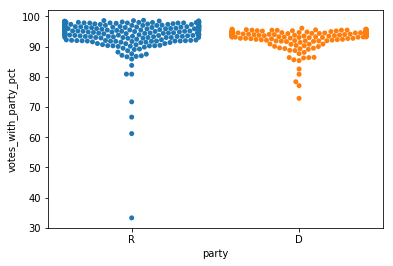

In [82]:
sns.swarmplot(x=party, y=vote_party)

In [23]:
#At-large districts mean there are multiple reps per district
print ("Number of at-large voting districts:",
    (df_house.at_large == True).sum())

Number of at-large voting districts: 14


For congress 103 to most recent
- retrieve party_vote_pct and party for each congress and store in df
- take average party_votes_pct grouped by party
- plot the average over time

In [113]:
def drop_zero_pct(cell):
    if cell == 0:
        return 'NaN'
    else:
        return cell

In [155]:
from congress import Congress

congress = Congress('qa1qfTzGinGGLcNCbinp2OTlI2SvzBe4KFgxYobm')

In [145]:
test_df = pd.DataFrame(congress.votes.party(chamber='house', congress=103)['members'])

In [146]:
test_df.head(3)

,api_uri,district,id,name,notes,party,party_votes_pct,rank,state,total_votes,votes_with_party
0,https://api.propublica.org/congress/v1/members...,3,H000514,Paul B. Henry,Died 7/1/1993,R,0.00,1,MI,387,0
1,https://api.propublica.org/congress/v1/members...,1,L000096,Steve Largent,,R,0.00,2,OK,1,0
2,https://api.propublica.org/congress/v1/members...,5,T000074,Gene Taylor,,D,52.07,3,MS,1122,579


In [159]:
hist_partyvotes = pd.DataFrame(columns=['congress', 'party', 'party_votes_pct'])

for c in range(103,116):
    #congress = Congress('qa1qfTzGinGGLcNCbinp2OTlI2SvzBe4KFgxYobm')
    df = pd.DataFrame(congress.votes.party(chamber='house', congress=c)['members'])
    df['congress'] = c
    hist_partyvotes = pd.concat([hist_partyvotes, df])
    del df

In [197]:
#remove 0s from party_votes_pct
hist_partyvotes = hist_partyvotes.drop(hist_partyvotes[hist_partyvotes.party_votes_pct == 0].index)

In [214]:
#calculate mean per party by congress
average_partyvote = hist_partyvotes.groupby(by=['party', 'congress'], as_index=False).mean()

In [216]:
#calculate mean by congress only and put into plot

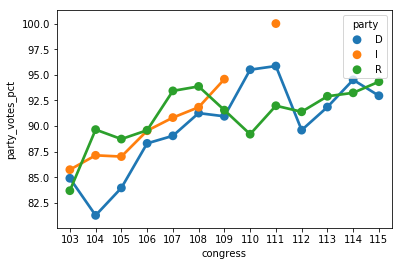

In [209]:
sns.pointplot(x=average_partyvote.congress, y=average_partyvote.party_votes_pct, hue=average_partyvote.party)

In [98]:
congress.members.filter('house')[0]['members']

[{'api_uri': 'https://api.propublica.org/congress/v1/members/A000374.json',
  'at_large': False,
  'contact_form': None,
  'crp_id': 'N00036633',
  'cspan_id': '76236',
  'date_of_birth': '1954-09-16',
  'district': '5',
  'dw_nominate': 0.497,
  'facebook_account': 'CongressmanRalphAbraham',
  'fax': '202-225-5639',
  'fec_candidate_id': 'H4LA05221',
  'first_name': 'Ralph',
  'gender': 'M',
  'geoid': '2205',
  'google_entity_id': '/m/012dwd7_',
  'govtrack_id': '412630',
  'icpsr_id': '21522',
  'id': 'A000374',
  'ideal_point': None,
  'in_office': True,
  'last_name': 'Abraham',
  'leadership_role': None,
  'middle_name': None,
  'missed_votes': 8,
  'missed_votes_pct': 0.91,
  'next_election': '2018',
  'ocd_id': 'ocd-division/country:us/state:la/cd:5',
  'office': '417 Cannon House Office Building',
  'party': 'R',
  'phone': '202-225-8490',
  'rss_url': 'https://abraham.house.gov/rss.xml',
  'seniority': '4',
  'short_title': 'Rep.',
  'state': 'LA',
  'suffix': None,
  'title'

# Congressional Districts

In [4]:
import json
import os
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# spatial stuff
import geopandas as gpd
import fiona
import folium
import shapely

- shapefiles from https://www.census.gov/geo/maps-data/data/cbf/cbf_cds.html

In [5]:
ppath = '../Project_tsds/rawdata/congress_disticts2017_500k/'
districts = gpd.read_file(ppath+'cb_2017_us_cd115_500k.shp')

In [9]:
districts.head(3)
#GEOID or STATEFP gives congressional districts

,STATEFP,CD115FP,AFFGEOID,GEOID,LSAD,CDSESSN,ALAND,AWATER,geometry
0,13,09,5001500US1309,1309,C2,115,13497964615,411754565,"POLYGON ((-84.65622499999999 34.730984, -84.65..."
1,19,04,5001500US1904,1904,C2,115,58937921470,264842664,"POLYGON ((-96.63970399999999 42.737071, -96.63..."
2,17,10,5001500US1710,1710,C2,115,777307694,31695461,"POLYGON ((-88.19882 42.41557, -88.198601 42.41..."


In [12]:
select = districts[districts.GEOID == '1904']

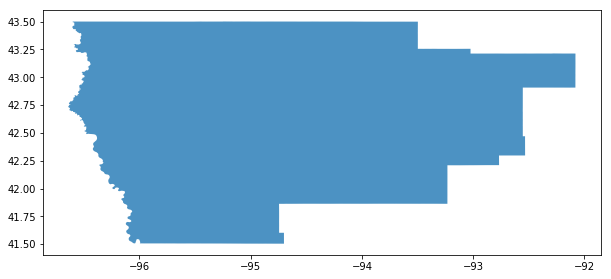

In [13]:
select.plot(markersize=5,figsize=(10, 10), alpha=.8)

In [ ]:
df

In [73]:
#world plots by gpd
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
usa = world[world.name == 'United States']